In [1]:
import scanpy as sc
import anndata as ad
import scipy
from scipy.sparse import issparse, csr_matrix
import gseapy as gp
import decoupler as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Optional, Tuple, Dict, Any
import warnings
import gc
import re
import psutil
import logging
import os

# configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# [Data loading] Prepare adata for pre-proc

In [ ]:
# load male and female adata and aggregate
adata_corrected_female = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_female_2025.h5ad')
adata_corrected_male = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_male_2025.h5ad')

In [ ]:
adata_corrected_male

In [ ]:
adata_corrected_female

In [ ]:
same_set = set(adata_corrected_female.var_names) == set(adata_corrected_male.var_names)
print("Same gene set?", same_set)
print("A genes:", adata_corrected_female.n_vars, "B genes:", adata_corrected_male.n_vars)

#### Concat the two pools and name their batches

In [ ]:
for adx in (adata_corrected_female, adata_corrected_male):
    adx.var_names = adx.var_names.astype(str)
    adx.var_names_make_unique()

In [ ]:
adata_cellbender_combined = ad.concat(
    {"male": adata_corrected_male, "female": adata_corrected_female},
    axis=0,
    join="inner",         # use "outer" if you want union of genes (missing filled with 0)
    label="batch",
    index_unique=None     # keep original cell barcodes (ensure they won't collide)
)

In [ ]:
adata_cellbender_combined

In [ ]:
adata_cellbender_combined.obs['batch'].value_counts()

In [ ]:
def remove_duplicates(adata, axis='obs', strategy='first'):
    """
    Remove barcode duplicates with different strategies
    
    Parameters:
    - axis: 'obs' for cells, 'var' for genes
    - strategy: 'first', 'last', 'highest_counts' (for obs only)
    """
    if axis == 'obs':
        index = adata.obs.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        elif strategy == 'highest_counts':
            # Keep the cell with highest UMI counts among duplicates
            keep_indices = []
            for name in index.unique():
                name_mask = index == name
                if name_mask.sum() > 1:  # If duplicated
                    if 'nCount_RNA' in adata.obs.columns:
                        best_idx = adata.obs.loc[name_mask, 'nCount_RNA'].idxmax()
                        keep_indices.extend([i for i, idx in enumerate(adata.obs.index) if idx == best_idx])
                    else:
                        # Fall back to first if no count info
                        keep_indices.append(np.where(name_mask)[0][0])
                else:
                    keep_indices.extend(np.where(name_mask)[0])
            keep_mask = np.zeros(adata.n_obs, dtype=bool)
            keep_mask[keep_indices] = True
        
        return adata[keep_mask].copy()
    
    else:  # axis == 'var'
        index = adata.var.index
        if strategy == 'first':
            keep_mask = ~index.duplicated(keep='first')
        elif strategy == 'last':
            keep_mask = ~index.duplicated(keep='last')
        else:
            keep_mask = ~index.duplicated(keep='first')  # Default to first
        
        return adata[:, keep_mask].copy()

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_cellbender_combined.shape
# Remove cell duplicates (keeping first occurrence)
adata_subset = remove_duplicates(adata_cellbender_combined, axis='obs', strategy='first')

In [ ]:
dup_mask = adata_subset.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_subset.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_subset.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
adata_subset

In [ ]:
# save the combined adata
adata_subset.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')

### Combine the cellbender layer

In [ ]:
# load datasets
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/cellbender_corrected_aggr_2025_dedup.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/ERCC1_KO_mice_aggr_updated.h5ad')

In [ ]:
adata_uncorrected.obs

In [ ]:
# Use regex to replace any suffix _2 through _8 with _1
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.replace(r'-[2-8]$', '-1', regex=True)

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
print("\n=== Removing Duplicates ===")
original_shape = adata_uncorrected.shape
# Remove cell duplicates (keeping first occurrence)
adata_uncorrected = remove_duplicates(adata_uncorrected, axis='obs', strategy='first')

In [ ]:
# check of cell ranger uncorrected data has duplicates
dup_mask = adata_uncorrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_uncorrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_uncorrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

In [ ]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [ ]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [ ]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [ ]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

In [ ]:
adata_combined.obs

In [ ]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

In [ ]:
adata_combined

# [Pre-proc] Normalization, feature selection, dim reduction

In [2]:
infile = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_combined.h5ad'

In [3]:
adata = sc.read_h5ad(infile)

In [4]:
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    uns: 'log1p', 's

In [5]:
adata.X = adata.layers['cellbender']

In [6]:
adata.obs['total_counts_cb'] = adata.X.sum(axis=1).A1

In [7]:
# add the vars you need to get per-gene metrics on (for corrected counts add new var columns)
adata.var['mt_cb'] = adata.var_names.str.startswith('mt-')
adata.var['ribo_cb'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb_cb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 60965 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'total_counts_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
 

In [8]:
# cut off cells to compare cellbender vs uncorrected counts on the same scale
adata = adata[adata.obs['total_counts_mt_cb'] < 300]
adata = adata[adata.obs['total_counts_mt'] < 300]

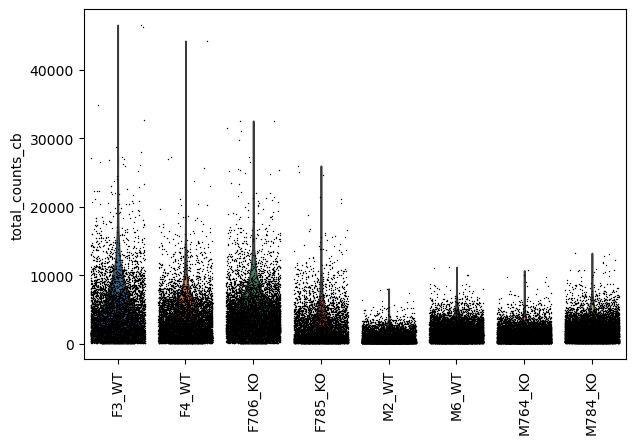

In [15]:
sc.pl.violin(
    adata,
    ["total_counts_cb"],
    groupby='sample_id',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

#### Filter cells based on cell bender probability

In [10]:
# cell bender probability of being cell and not soup
adata = adata[adata.obs['cell_probability'] > 0.99]
# remove the barcodes that are predicted to be doublets
adata = adata[adata.obs['predicted_doublet'] == False]

In [11]:
# get the number of F and M cells from sex obs
adata.obs['sex'].value_counts()

sex
M    33155
F    26567
Name: count, dtype: int64

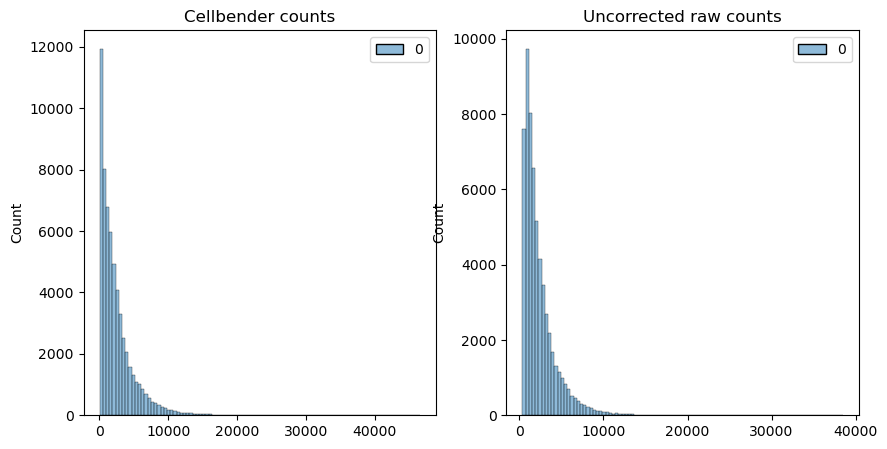

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Uncorrected raw counts")
plt.show()

## scVI normalization 
#### correct for sex specific read depth bias

In [13]:
# Check mean read depth by sex
depth_by_sex = adata.obs.groupby('sex')['total_counts_cb'].agg(['mean', 'std', 'count'])
print("\nRead depth by sex:")
print(depth_by_sex)

# Check depth by sample
depth_by_sample = adata.obs.groupby(['sample_id', 'sex'])['total_counts_cb'].mean()
print("\nRead depth by sample:")
print(depth_by_sample)

/tmp/ipykernel_63367/152123069.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  depth_by_sex = adata.obs.groupby('sex')['total_counts_cb'].agg(['mean', 'std', 'count'])
/tmp/ipykernel_63367/152123069.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  depth_by_sample = adata.obs.groupby(['sample_id', 'sex'])['total_counts_cb'].mean()



Read depth by sex:
            mean          std  count
sex                                 
F    3624.008733  3346.698889  26567
M    1539.229468  1327.592831  33155

Read depth by sample:
sample_id  sex
F3_WT      F      4486.297747
           M              NaN
F4_WT      F      3317.051589
           M              NaN
F706_KO    F      4274.262273
           M              NaN
F785_KO    F      2222.864108
           M              NaN
M2_WT      F              NaN
           M       924.588804
M6_WT      F              NaN
           M      1711.776451
M764_KO    F              NaN
           M      1322.247584
M784_KO    F              NaN
           M      1992.177810
Name: total_counts_cb, dtype: float64


In [14]:
housekeeping_genes = ['Actb', 'Gapdh', 'Pgk1', 'Rpl13a', 'Rplp0']
housekeeping_present = [g for g in housekeeping_genes if g in adata.var_names]
print(f"\nHousekeeping genes found: {housekeeping_present}")


Housekeeping genes found: ['Actb', 'Gapdh', 'Pgk1', 'Rpl13a', 'Rplp0']


In [ ]:
from scipy.stats import pearsonr

def analyze_sequencing_depth_bias(adata, sample_key='sample_id', sex_key='sex'):
    """
    Analyze sequencing depth bias in snRNA-seq data
    """
    print("\n=== Analyzing Sequencing Depth Bias ===")
    
    # Calculate total UMI counts per cell
    adata.obs['total_counts_cb'] = adata.X.sum(axis=1).A1
    
    # Calculate mean counts per sample
    sample_stats = adata.obs.groupby([sample_key, sex_key]).agg({
        'total_counts_cb': ['mean', 'median', 'std', 'count']
    }).round(2)
    
    print("Sample statistics:")
    print(sample_stats)
    
    return sample_stats

def calculate_gene_depth_correlations(adata, genes_to_test, sample_key='sample_id'):
    """
    Calculate correlations between gene expression and sequencing depth
    """
    print("\n=== Calculating Gene-Depth Correlations ===")
    
    correlations = {}
    p_values = {}
    
    for gene in genes_to_test:
        if gene in adata.var_names:
            gene_expr = adata[:, gene].X.toarray().flatten()
            total_counts = adata.obs['total_counts_cb'].values
            
            corr, p_val = pearsonr(gene_expr, total_counts)
            correlations[gene] = corr
            p_values[gene] = p_val
            
            print(f"{gene}: r={corr:.3f}, p={p_val:.3e}")
    
    return correlations, p_values

def setup_scvi_model(adata, batch_key='sample_id', categorical_covariates=None, continuous_covariates=None):
    """
    Set up and train scVI model for normalization
    """
    print("\n=== Setting up scVI Model ===")
    
    # Set up the model
    scvi.model.SCVI.setup_anndata(
        adata,
        batch_key=batch_key,
        categorical_covariate_keys=categorical_covariates,
        continuous_covariate_keys=continuous_covariates
    )
    
    # Create model
    model = scvi.model.SCVI(
        adata,
        n_layers=2,
        n_latent=30,
        gene_likelihood="nb"
    )
    
    print("scVI model created successfully")
    return model

def train_scvi_model(model, max_epochs=200, early_stopping=True):
    """
    Train the scVI model
    """
    print("\n=== Training scVI Model ===")
    
    # Train the model
    model.train(
        max_epochs=max_epochs,
        early_stopping=early_stopping,
        use_gpu=False  # CPU compatible
    )
    
    print("scVI model training completed")
    return model

def generate_normalized_data(model, adata):
    """
    Generate normalized data from trained scVI model
    """
    print("\n=== Generating Normalized Data ===")
    
    # Get the latent representation
    latent = model.get_latent_representation()
    
    # Get normalized expression
    normalized_expression = model.get_normalized_expression(
        library_size=10000,
        return_mean=True
    )
    
    # Add to adata
    adata.obsm['X_scvi'] = latent
    adata.layers['scvi_normalized'] = normalized_expression
    
    print("Normalized data generated successfully")
    return adata

# Create visualization functions
def plot_sequencing_depth_distribution(adata, sex_key='sex', sample_key='sample', output_dir='./'):
    """
    Plot sequencing depth distribution across samples and sexes
    """
    print("\n=== Creating Sequencing Depth Visualizations ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Total counts per cell by sex
    sns.boxplot(data=adata.obs, x=sex_key, y='total_counts', ax=axes[0,0])
    axes[0,0].set_title('Total UMI Counts per Cell by Sex')
    axes[0,0].set_ylabel('Total UMI Counts')
    
    # Plot 2: Total counts per sample
    sns.boxplot(data=adata.obs, x=sample_key, y='total_counts', hue=sex_key, ax=axes[0,1])
    axes[0,1].set_title('Total UMI Counts per Sample')
    axes[0,1].set_ylabel('Total UMI Counts')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Distribution histogram
    for sex in adata.obs[sex_key].unique():
        subset = adata.obs[adata.obs[sex_key] == sex]['total_counts']
        axes[1,0].hist(subset, alpha=0.6, label=sex, bins=50)
    axes[1,0].set_xlabel('Total UMI Counts')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of UMI Counts by Sex')
    axes[1,0].legend()
    
    # Plot 4: Sample means
    sample_means = adata.obs.groupby([sample_key, sex_key])['total_counts'].mean().reset_index()
    sns.barplot(data=sample_means, x=sample_key, y='total_counts', hue=sex_key, ax=axes[1,1])
    axes[1,1].set_title('Mean UMI Counts per Sample')
    axes[1,1].set_ylabel('Mean UMI Counts')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/sequencing_depth_analysis.png', dpi=300, bbox_inches='tight')
    print(f"Sequencing depth plots saved at: {output_dir}/sequencing_depth_analysis.png")
    plt.show()
    
    return fig

print("Workflow functions defined successfully")

# Create comprehensive visualization and analysis functions
def plot_gene_depth_correlations(adata, correlations, p_values, output_dir='./'):
    """
    Plot correlations between gene expression and sequencing depth
    """
    print("\n=== Creating Gene-Depth Correlation Plots ===")
    
    # Prepare data for plotting
    genes = list(correlations.keys())
    corr_values = list(correlations.values())
    p_vals = list(p_values.values())
    
    # Create significance indicator
    significance = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns' 
                   for p in p_vals]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Correlation barplot
    bars = axes[0,0].bar(range(len(genes)), corr_values, 
                        color=['red' if abs(c) > 0.3 else 'orange' if abs(c) > 0.1 else 'gray' 
                              for c in corr_values])
    axes[0,0].set_xlabel('Genes')
    axes[0,0].set_ylabel('Correlation with Sequencing Depth')
    axes[0,0].set_title('Gene Expression vs Sequencing Depth Correlations')
    axes[0,0].set_xticks(range(len(genes)))
    axes[0,0].set_xticklabels(genes, rotation=45)
    axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add significance annotations
    for i, (bar, sig) in enumerate(zip(bars, significance)):
        height = bar.get_height()
        axes[0,0].annotate(sig, xy=(bar.get_x() + bar.get_width()/2, height),
                          xytext=(0, 3 if height >= 0 else -15),
                          textcoords="offset points", ha='center', va='bottom')
    
    # Plot 2: P-values
    axes[0,1].bar(range(len(genes)), [-np.log10(p) for p in p_vals])
    axes[0,1].set_xlabel('Genes')
    axes[0,1].set_ylabel('-log10(p-value)')
    axes[0,1].set_title('Statistical Significance of Correlations')
    axes[0,1].set_xticks(range(len(genes)))
    axes[0,1].set_xticklabels(genes, rotation=45)
    axes[0,1].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
    axes[0,1].legend()
    
    # Plot 3 & 4: Example scatter plots for highest correlation genes
    top_genes = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:2]
    
    for idx, (gene, corr) in enumerate(top_genes):
        ax = axes[1, idx]
        if gene in adata.var_names:
            gene_expr = adata[:, gene].X.toarray().flatten()
            total_counts = adata.obs['total_counts'].values
            
            ax.scatter(total_counts, gene_expr, alpha=0.6)
            ax.set_xlabel('Total UMI Counts')
            ax.set_ylabel(f'{gene} Expression')
            ax.set_title(f'{gene} vs Sequencing Depth\n(r={corr:.3f})')
            
            # Add trend line
            z = np.polyfit(total_counts, gene_expr, 1)
            p = np.poly1d(z)
            ax.plot(total_counts, p(total_counts), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/gene_depth_correlations.png', dpi=300, bbox_inches='tight')
    print(f"Gene-depth correlation plots saved at: {output_dir}/gene_depth_correlations.png")
    plt.show()
    
    return fig

def compare_normalization_effectiveness(adata, correlations_before, correlations_after, 
                                      p_values_before, p_values_after, output_dir='./'):
    """
    Compare normalization effectiveness by showing before/after correlations
    """
    print("\n=== Comparing Normalization Effectiveness ===")
    
    genes = list(correlations_before.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Before vs After correlations
    axes[0,0].scatter(list(correlations_before.values()), list(correlations_after.values()), 
                     s=100, alpha=0.7)
    axes[0,0].plot([-1, 1], [-1, 1], 'r--', alpha=0.7, label='No change')
    axes[0,0].set_xlabel('Correlation Before Normalization')
    axes[0,0].set_ylabel('Correlation After Normalization')
    axes[0,0].set_title('Correlation Changes: Before vs After scVI')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Add gene labels
    for i, gene in enumerate(genes):
        axes[0,0].annotate(gene, 
                          (correlations_before[gene], correlations_after[gene]),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot 2: Improvement in correlations
    improvements = {gene: abs(correlations_before[gene]) - abs(correlations_after[gene]) 
                   for gene in genes}
    
    bars = axes[0,1].bar(range(len(genes)), list(improvements.values()),
                        color=['green' if v > 0 else 'red' for v in improvements.values()])
    axes[0,1].set_xlabel('Genes')
    axes[0,1].set_ylabel('Correlation Improvement\n(|Before| - |After|)')
    axes[0,1].set_title('Normalization Improvement per Gene')
    axes[0,1].set_xticks(range(len(genes)))
    axes[0,1].set_xticklabels(genes, rotation=45)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Plot 3: Distribution comparison
    before_abs = [abs(c) for c in correlations_before.values()]
    after_abs = [abs(c) for c in correlations_after.values()]
    
    axes[1,0].hist(before_abs, alpha=0.7, label='Before scVI', bins=10, color='red')
    axes[1,0].hist(after_abs, alpha=0.7, label='After scVI', bins=10, color='blue')
    axes[1,0].set_xlabel('Absolute Correlation')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Absolute Correlations')
    axes[1,0].legend()
    
    # Plot 4: Summary statistics
    stats_data = pd.DataFrame({
        'Before': list(correlations_before.values()),
        'After': list(correlations_after.values()),
        'Gene': genes
    })
    
    stats_melted = stats_data.melt(id_vars=['Gene'], var_name='Condition', value_name='Correlation')
    sns.boxplot(data=stats_melted, x='Condition', y='Correlation', ax=axes[1,1])
    axes[1,1].set_title('Overall Correlation Distribution')
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/normalization_comparison.png', dpi=300, bbox_inches='tight')
    print(f"Normalization comparison plots saved at: {output_dir}/normalization_comparison.png")
    plt.show()
    
    # Print summary statistics
    print("\n=== Normalization Summary ===")
    print(f"Mean absolute correlation before: {np.mean(before_abs):.3f}")
    print(f"Mean absolute correlation after: {np.mean(after_abs):.3f}")
    print(f"Mean improvement: {np.mean(before_abs) - np.mean(after_abs):.3f}")
    
    return fig

# Create the complete workflow function
def complete_scvi_normalization_workflow(adata, sample_key='sample', sex_key='sex', 
                                       housekeeping_genes=None, output_dir='./'):
    """
    Complete workflow for scVI normalization of snRNA-seq data with sequencing depth bias
    """
    print("=== STARTING COMPLETE scVI NORMALIZATION WORKFLOW ===")
    
    if housekeeping_genes is None:
        housekeeping_genes = ['GAPDH', 'ACTB', 'TUBB', 'RPL13A', 'RPS18', 'PPIA', 'HPRT1', 'TBP']
    
    # Step 1: Analyze initial sequencing depth bias
    sample_stats = analyze_sequencing_depth_bias(adata, sample_key, sex_key)
    
    # Step 2: Calculate pre-normalization correlations
    correlations_before, p_values_before = calculate_gene_depth_correlations(
        adata, housekeeping_genes, sample_key)
    
    # Step 3: Plot initial analysis
    plot_sequencing_depth_distribution(adata, sex_key, sample_key, output_dir)
    plot_gene_depth_correlations(adata, correlations_before, p_values_before, output_dir)
    
    # Step 4: Set up and train scVI model
    model = setup_scvi_model(adata, batch_key=sample_key, 
                           categorical_covariates=[sex_key],
                           continuous_covariates=['total_counts'])
    
    # Step 5: Train model
    trained_model = train_scvi_model(model, max_epochs=200, early_stopping=True)
    
    # Step 6: Generate normalized data
    adata_normalized = generate_normalized_data(trained_model, adata.copy())
    
    # Step 7: Calculate post-normalization correlations using normalized data
    # Temporarily replace X with normalized data for correlation calculation
    original_X = adata_normalized.X.copy()
    adata_normalized.X = adata_normalized.layers['scvi_normalized']
    
    correlations_after, p_values_after = calculate_gene_depth_correlations(
        adata_normalized, housekeeping_genes, sample_key)
    
    # Restore original X
    adata_normalized.X = original_X
    
    # Step 8: Compare normalization effectiveness
    compare_normalization_effectiveness(adata_normalized, correlations_before, correlations_after,
                                      p_values_before, p_values_after, output_dir)
    
    print("\n=== WORKFLOW COMPLETED SUCCESSFULLY ===")
    
    return adata_normalized, trained_model, {
        'correlations_before': correlations_before,
        'correlations_after': correlations_after,
        'p_values_before': p_values_before,
        'p_values_after': p_values_after,
        'sample_stats': sample_stats
    }

print("Complete workflow functions created successfully")

### Normalization

In [ ]:
adata.X = adata.layers['cellbender'].copy()
#adata.X = adata.layers['counts'].copy()
# normalize counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm_cb"] = sc.pp.log1p(scales_counts["X"], copy=True)
#adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_33622/1039617066.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.layers['cellbender'].copy()


In [56]:
adata

AnnData object with n_obs × n_vars = 59722 × 32285
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    uns: 'log1p', 's

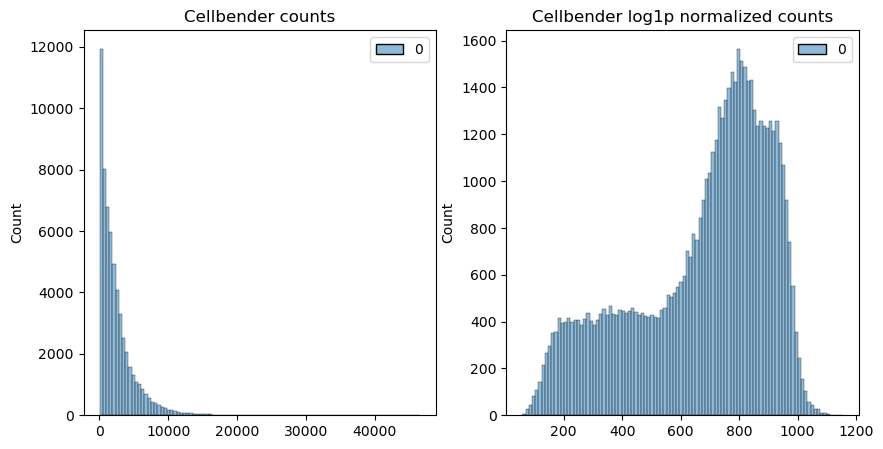

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Cellbender log1p normalized counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

#### Check for mislabeling of gender samples and key pathways

In [58]:
# check if these genes are present in the data 
list_male_genes = [ 'Eif2s3y', 'Ddx3y', 'Kdm5d', 'Uty', 'Zfy1', 'Zfy2', 'Sry', 'Rbmy1a1', 'Ssty1', 
    'Ssty2', 'Tspy-ps1', 'Prss21', 'Mid1', 'Ube1y', 'Smcy', 'Usp9y', 'Zfy-ps1'
    ]

# Find available Y genes
available_male_genes = [gene for gene in list_male_genes if gene in adata.var_names]
print(f"\nFound {len(available_male_genes)} Y chromosome genes in dataset:")
for gene in available_male_genes:
    print(f"{gene}")



Found 12 Y chromosome genes in dataset:
Eif2s3y
Ddx3y
Kdm5d
Uty
Zfy1
Zfy2
Sry
Ssty1
Ssty2
Prss21
Mid1
Usp9y


In [59]:
### DDR genes 
dna_damage_response = ['Atr', 'Atm', 'Chek1', 'Chek2', 'Trp53', 'Mdm2', 'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Xrcc6', 'Prkdc', 'Parp1', 'Xrcc1', 'Fancd2']

# Find available DDR genes
available_ddr_genes = [gene for gene in dna_damage_response if gene in adata.var_names]
print(f"\nFound {len(available_ddr_genes)} DNA damage response genes in dataset:")
for gene in available_ddr_genes:
    print(f"{gene}")


Found 15 DNA damage response genes in dataset:
Atr
Atm
Chek1
Chek2
Trp53
Mdm2
Cdkn1a
Brca1
Brca2
Rad51
Xrcc6
Prkdc
Parp1
Xrcc1
Fancd2


In [60]:
adata.X = adata.layers['log1p_norm_cb']

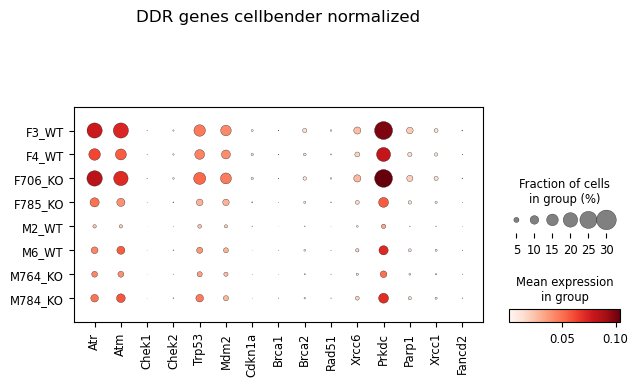

In [63]:
# plot gene expression dotplot of these genes
# sc.pl.dotplot(adata, available_male_genes, groupby='sample_id', title="Y chromosome genes cellbender normalized")
sc.pl.dotplot(adata, available_ddr_genes, groupby='sample_id', title="DDR genes cellbender normalized")
plt.show()

In [73]:
from scipy import stats
adata_female = adata[adata.obs['sex'] == 'F']
adata_male = adata[adata.obs['sex'] == 'M']

In [80]:
from scipy import stats

# Calculate correlation between total counts and DDR gene expression
ddr_genes = ['Atr', 'Chek1', 'Chek2', 'Trp53', 'Mre11', 
             'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Prkdc', 
             'Parp1', 'Xrcc1', 'Fancd2']

In [82]:
housekeeping_genes = ['Actb', 'Gapdh', 'Pgk1', 'Rpl13a', 'Rplp0']

In [83]:
# For each DDR gene
for gene in housekeeping_genes:
    if gene in adata.var_names:
        expr = adata_female[:, gene].X.toarray().flatten()
        total_counts = adata_female.obs['total_counts'].values
        
        corr, pval = stats.spearmanr(total_counts, expr)
        print(f"{gene}: correlation = {corr:.3f}, p-value = {pval:.3e}")

Actb: correlation = 0.379, p-value = 0.000e+00
Gapdh: correlation = 0.409, p-value = 0.000e+00
Pgk1: correlation = 0.331, p-value = 0.000e+00
Rpl13a: correlation = -0.000, p-value = 9.392e-01
Rplp0: correlation = -0.018, p-value = 3.077e-03


In [84]:
# For each DDR gene
for gene in housekeeping_genes:
    if gene in adata.var_names:
        expr = adata_male[:, gene].X.toarray().flatten()
        total_counts = adata_male.obs['total_counts'].values
        
        corr, pval = stats.spearmanr(total_counts, expr)
        print(f"{gene}: correlation = {corr:.3f}, p-value = {pval:.3e}")

Actb: correlation = 0.368, p-value = 0.000e+00
Gapdh: correlation = -0.050, p-value = 1.664e-19
Pgk1: correlation = 0.216, p-value = 0.000e+00
Rpl13a: correlation = -0.035, p-value = 2.547e-10
Rplp0: correlation = -0.040, p-value = 2.833e-13


#### Feature selection

In [ ]:
# Filter out genes with very low expression
sc.pp.filter_genes(adata, min_cells=10)  # Remove genes expressed in <10 cells
sc.pp.filter_genes(adata, min_counts=3)  # Remove genes with <3 total counts

In [ ]:
# set the normalized counts to the active layer
adata.X = adata.layers['log1p_norm_cb']

In [ ]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=2000)

In [ ]:
sc.pl.highly_variable_genes(adata)

### Dim reduction

In [ ]:
adata.obs['total_counts_cb'] = np.array(adata.layers['cellbender'].sum(axis=1)).flatten()

In [ ]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts_cb", "pct_counts_mt_cb"])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
sc.pp.neighbors(adata)

In [ ]:
sc.pl.pca_scatter(adata, color="total_counts_cb")

# [Labeling] Clustering, Annotation, Markers

In [ ]:
sc.tl.umap(adata, random_state=42, min_dist=1, spread=1)
sc.tl.leiden(adata, key_added=f"leiden", resolution=0.50)

In [ ]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

### Marker genes per cluster

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')  # You can choose other methods like 'wilcoxon', 'logreg'
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

In [ ]:
marker_genes = [
    "Ano4", "Prkar1a", "Tnxb", "Egfr", "Gsn",
    "Abi3bp", "Ptprd", "Col22a1", "Adamts20", "App", "Trpc3", "Cacna1c",
    "Slc35f1", "Hs6st3", "Chodl", "Pax7", "Flt1", "Mecom",
    "Dach1", "Pecam1", "F13a1", "Mctp1", "Slc9a9", "Sorbs2",
    "Myh1", "Kcnn2", "Acss2", "Fhl1"
]
sc.pl.umap(adata,color=[*marker_genes,"leiden"],legend_loc="on data",frameon=False)

## Celltypist

In [ ]:
import celltypist
from celltypist import models

class CellTypistCustomWorkflow:
    """
    A comprehensive workflow for training custom CellTypist models and 
    transferring cell type labels.
    """
    
    def __init__(self, output_dir="./celltypist_results"):
        """Initialize the workflow with output directory."""
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.reference_adata = None
        self.target_adata = None
        self.custom_model = None
        
    def load_data(self, reference_path, target_path):
        """
        Load reference and target datasets.
        
        Parameters:
        -----------
        reference_path : str
            Path to reference dataset (4 samples with cell type labels)
        target_path : str  
            Path to target dataset (8 new samples)
        """
        print("🔄 Loading datasets...")
        
        # Load reference data (4 samples with labels)
        if reference_path.endswith('.h5ad'):
            self.reference_adata = sc.read_h5ad(reference_path)
        else:
            # Assume it's a matrix file - adapt as needed
            self.reference_adata = sc.read(reference_path)
            
        # Load target data (8 new samples)  
        if target_path.endswith('.h5ad'):
            self.target_adata = sc.read_h5ad(target_path)
        else:
            self.target_adata = sc.read(target_path)
            
        print(f"✅ Reference data: {self.reference_adata.shape}")
        print(f"✅ Target data: {self.target_adata.shape}")
        
        # Check if reference has cell type labels
        if 'cell_type' not in self.reference_adata.obs.columns:
            print("⚠️  Warning: No 'cell_type' column found in reference data")
            print("   Available columns:", list(self.reference_adata.obs.columns))
            
    def preprocess_data(self):
        """
        Preprocess both reference and target datasets according to 
        CellTypist requirements.
        """
        print("🔄 Preprocessing data...")
        
        def preprocess_adata(adata, dataset_name):
            """Helper function to preprocess individual dataset."""
            print(f"   Processing {dataset_name}...")
            
            # Make variable names unique
            adata.var_names_unique()
            
            # Basic filtering
            sc.pp.filter_cells(adata, min_genes=200)  # Filter cells
            sc.pp.filter_genes(adata, min_cells=3)    # Filter genes
            
            # Store raw counts
            adata.raw = adata
            
            # Normalize to 10,000 counts per cell (CellTypist requirement)
            sc.pp.normalize_total(adata, target_sum=1e4)
            
            # Log1p transformation
            sc.pp.log1p(adata)
            
            return adata
        
        # Preprocess both datasets
        self.reference_adata = preprocess_adata(self.reference_adata, "reference")
        self.target_adata = preprocess_adata(self.target_adata, "target")
        
        print("✅ Preprocessing completed")
        
    def train_custom_model(self, cell_type_column='cell_type'):
        """
        Train a custom CellTypist model using reference data.
        
        Parameters:
        -----------
        cell_type_column : str
            Name of column containing cell type annotations
        """
        print("🔄 Training custom CellTypist model...")
        
        # Prepare training data
        # CellTypist expects a DataFrame with genes as rows, cells as columns
        training_data = pd.DataFrame(
            self.reference_adata.X.T if hasattr(self.reference_adata.X, 'toarray') 
            else self.reference_adata.X.T,
            index=self.reference_adata.var_names,
            columns=self.reference_adata.obs_names
        )
        
        # Get cell type labels
        labels = self.reference_adata.obs[cell_type_column]
        
        # Train the model
        self.custom_model = celltypist.train(
            training_data, 
            labels, 
            n_jobs=1,
            max_iter=100,
            use_SGD=True
        )
        
        # Save the custom model
        model_path = self.output_dir / "custom_celltypist_model.pkl"
        self.custom_model.write(str(model_path))
        
        print(f"✅ Custom model trained and saved to {model_path}")
        print(f"   Model includes {len(self.custom_model.cell_types)} cell types:")
        print(f"   {list(self.custom_model.cell_types)}")
        
    def predict_cell_types(self):
        """
        Apply the custom model to predict cell types in target data.
        """
        print("🔄 Predicting cell types in target samples...")
        
        if self.custom_model is None:
            raise ValueError("No custom model found. Train model first.")
            
        # Prepare target data for prediction
        target_data = pd.DataFrame(
            self.target_adata.X.T if hasattr(self.target_adata.X, 'toarray') 
            else self.target_adata.X.T,
            index=self.target_adata.var_names,
            columns=self.target_adata.obs_names
        )
        
        # Make predictions
        predictions = celltypist.annotate(
            target_data,
            model=self.custom_model,
            majority_voting=True
        )
        
        # Add predictions to target adata
        self.target_adata.obs['predicted_cell_type'] = predictions.predicted_labels.predicted_labels
        self.target_adata.obs['prediction_confidence'] = predictions.predicted_labels.conf_score
        
        # Also store probability matrix
        prob_matrix = predictions.probability_matrix
        for cell_type in prob_matrix.columns:
            self.target_adata.obs[f'prob_{cell_type}'] = prob_matrix[cell_type].values
            
        print("✅ Cell type prediction completed")
        print(f"   Predicted cell types: {self.target_adata.obs['predicted_cell_type'].unique()}")
        
    def quality_control_analysis(self):
        """
        Perform quality control analysis of predictions.
        """
        print("🔄 Performing quality control analysis...")
        
        # Prediction confidence distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Confidence score distribution
        axes[0,0].hist(self.target_adata.obs['prediction_confidence'], bins=50, alpha=0.7)
        axes[0,0].axvline(0.5, color='red', linestyle='--', label='Threshold=0.5')
        axes[0,0].set_xlabel('Prediction Confidence')
        axes[0,0].set_ylabel('Number of Cells')
        axes[0,0].set_title('Distribution of Prediction Confidence Scores')
        axes[0,0].legend()
        
        # Cell type distribution
        cell_type_counts = self.target_adata.obs['predicted_cell_type'].value_counts()
        axes[0,1].pie(cell_type_counts.values, labels=cell_type_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Predicted Cell Type Distribution')
        
        # Confidence by cell type
        sns.boxplot(data=self.target_adata.obs, x='predicted_cell_type', 
                   y='prediction_confidence', ax=axes[1,0])
        axes[1,0].set_xlabel('Predicted Cell Type')
        axes[1,0].set_ylabel('Confidence Score')
        axes[1,0].set_title('Prediction Confidence by Cell Type')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Low confidence cells
        low_conf_threshold = 0.5
        low_conf_cells = (self.target_adata.obs['prediction_confidence'] < low_conf_threshold).sum()
        total_cells = len(self.target_adata.obs)
        
        axes[1,1].bar(['High Confidence', 'Low Confidence'], 
                     [total_cells - low_conf_cells, low_conf_cells],
                     color=['green', 'orange'])
        axes[1,1].set_ylabel('Number of Cells')
        axes[1,1].set_title(f'Cells by Confidence (Threshold={low_conf_threshold})')
        
        plt.tight_layout()
        qc_plot_path = self.output_dir / "quality_control_analysis.png"
        plt.savefig(qc_plot_path, dpi=300, bbox_inches='tight')
        print(f"   QC plots saved to {qc_plot_path}")
        plt.close()
        
    def create_visualizations(self):
        """
        Create comprehensive visualizations of the results.
        """
        print("🔄 Creating visualizations...")
        
        # Compute UMAP for target data
        sc.pp.highly_variable_genes(self.target_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        sc.pp.pca(self.target_adata, svd_solver='arpack')
        sc.pp.neighbors(self.target_adata, n_neighbors=10, n_pcs=40)
        sc.tl.umap(self.target_adata)
        
        # Create UMAP plots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # UMAP colored by predicted cell types
        sc.pl.umap(self.target_adata, color='predicted_cell_type', 
                  ax=axes[0], show=False, frameon=False)
        axes[0].set_title('UMAP: Predicted Cell Types')
        
        # UMAP colored by prediction confidence
        sc.pl.umap(self.target_adata, color='prediction_confidence', 
                  ax=axes[1], show=False, frameon=False)
        axes[1].set_title('UMAP: Prediction Confidence')
        
        plt.tight_layout()
        umap_plot_path = self.output_dir / "umap_visualization.png"
        plt.savefig(umap_plot_path, dpi=300, bbox_inches='tight')
        print(f"   UMAP plots saved to {umap_plot_path}")
        plt.close()
        
        # Create cell type dendrogram for validation
        if len(self.target_adata.obs['predicted_cell_type'].unique()) > 1:
            try:
                sc.tl.dendrogram(self.target_adata, groupby='predicted_cell_type')
                
                fig, ax = plt.subplots(figsize=(10, 6))
                sc.pl.dendrogram(self.target_adata, groupby='predicted_cell_type', 
                               ax=ax, show=False)
                ax.set_title('Cell Type Dendrogram')
                
                dendro_plot_path = self.output_dir / "cell_type_dendrogram.png"
                plt.savefig(dendro_plot_path, dpi=300, bbox_inches='tight')
                print(f"   Dendrogram saved to {dendro_plot_path}")
                plt.close()
            except Exception as e:
                print(f"   ⚠️  Could not create dendrogram: {e}")

In [ ]:
output_directory = "./celltypist_results"
workflow = CellTypistCustomWorkflow(output_directory)

In [ ]:
workflow.load_data(reference_path, target_path)

In [ ]:
workflow.preprocess_data()

In [ ]:
workflow.train_custom_model('cell_type')

In [ ]:
workflow.predict_cell_types()

In [ ]:
workflow.quality_control_analysis()

In [ ]:
workflow.create_visualizations()

In [ ]:
workflow.save_results()

In [ ]:
adata.write('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_annotated_v2.h5ad')